# EnigmaNet: A Neural Network Framework for Eplipesy Classification
### This is a script that uses Keras to predict epilepsy outcomes

## Script Details
This script is designed to run with the following configuration:
* Keras
* TensorFlow backend
* PlaidML backend (if using Radeon GPU)
* Tabular data (Excel or CSVs)

## Dependencies
Run the following command to pip install all dependencies
```
pip install numpy pandas sklearn matplotlib scipy keras_tqdm
```

Also install NeuroCombat at https://github.com/ncullen93/neuroCombat

## Path to Data
Define path to tabular data


In [1]:
csvPath = '/Users/sid/Documents/Projects/Enigma-ML/Dataset/Diffusion/FA.csv'

## Define Script Parameters
Define parameters that control script flow

In [2]:
classSel = 'Dx'             # Class labels
dBegin = 'ACR'              # Column where data begins
dEnd = 'UNC-R'   # Column where data ends
cBegin = 'Site'             # Column where covariates/demographics begin
cEnd = 'Sex'                # Column where covariates/demographics end
fillmissing = True          # Fill missing?
harmonize = True            # Run ComBat harmonization?
scaleData = False            # Rescale data?
dataSplit = 0.10            # Percent of data to remove for validation
nEpochs = 200               # Training number of epochs
bSize = 50                  # Training batch size
plotType = 'Normal'         # Type of ComBat graphs to save ('Histogram' or 'Normal')

## Define ComBat Harmonization Parameters
Python implementation of ComBat is currently being used, which can be found at https://github.com/ncullen93/neuroCombat

In [3]:
# Combat Variables
if harmonize:
    batchVar = 'Site'           # Batch effect variable
    discreteVar = ['Dx','Sex']  # Variables which are categorical that you want to predict
    continuousVar = ['Age']     # Variables which are continuous that you want to predict

## Import Required Modules
Import all modules required to process the script

In [4]:
import numpy as np
import pandas as pd
from neuroCombat import neuroCombat
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import cohen_kappa_score
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.callbacks import EarlyStopping
from keras_tqdm import TQDMNotebookCallback
import matplotlib.pyplot as plt
import scipy.stats
import random
import os

Using TensorFlow backend.


## Dependent Function
Functions that the scrips will depend on

In [5]:
def classfill(dFrame, classSel, idxRange):
    """Fills missing values with means of a class
    
    Inputs
    ------
    dFrame:   Pandas dataframe to process (type: dataframe)
            
    classSel: String indicating dataframe column name containing class information
    
    idxRange: 2x1 vector indicating lower and upper bound of data to fill in dataframe
              idxRange[0] is lower bound
              idxRange[1] is upper bound

    Returns
    -------
    data:     Dataframe will all missing values filled
    """
    uniqClass = dFrame[classSel].unique()           # All unique classes
    print('...found ' + str(uniqClass.size) + ' classes')
    print('...filling missing data with class means')
    data = dFrame.loc[:, idxRange[0]:idxRange[1]]                 # Extract all numerical value from 'dBegin' onwards
    for c in uniqClass:
        classIdx = dFrame.loc[:, classSel] == c     # Index where class is uniqClass = c
        for n in range(len(data.columns)):
            nanIdx = data.iloc[:,n].isnull()           # Index missing values
            # Compute mean of class values without nans
            # Because a Series of booleans cannot be used to index a dataframe, use the values attribute
            # to extract a bool array
            mu = np.nanmean(data.iloc[classIdx.values, n])
            data.iloc[nanIdx.values, n] = mu
    dFrame.loc[:,idxRange[0]:idxRange[1]] = data
    return dFrame

## Load Files and Manipulate
Load tabular data and prime it for deep learning

In [6]:
dFrame = pd.read_csv(csvPath)           # Dataframe
if fillmissing:
    dFrame = classfill(dFrame, classSel, [dBegin, dEnd])
else:
    print('...skip fill missing')

# Run combat
cData = neuroCombat(data=dFrame.loc[:,dBegin:dEnd],
                      covars=dFrame.loc[:,cBegin:cEnd],
                      batch_col=batchVar,
                      discrete_cols=discreteVar,
                      continuous_cols=continuousVar)

data = np.array(dFrame.loc[:, dBegin:dEnd])     # Preserve non-harmonized data

# Scale data
scaler = StandardScaler()   # Initialize scaler
if scaleData:
    cData = scaler.fit_transform(cData)
    data = scaler.fit_transform(data)

...found 2 classes
...filling missing data with class means
Creating design matrix..
Standardizing data across features..
Fitting L/S model and finding priors..
Finding parametric adjustments..
Final adjustment of data..


## Split Data for Training and Evaluation
Data needs to be split for trianing and evaluation

In [7]:
# Split into training and validation sets and scale
if harmonize:
    X_train, X_test, y_train, y_test = train_test_split(cData, dFrame.loc[:, classSel], test_size=dataSplit, random_state=0)
else:
    X_train, X_test, y_train, y_test = train_test_split(data, dFrame.loc[:, classSel], test_size=dataSplit, random_state=0)

## Build Model and Train
A perceptron is constructed here for training

In [8]:
# Choose whether data/labels or X_Train,y_train
dataIn = X_train
labelsIn = y_train

# Initialising the ANN
model = Sequential()

# Adding the Single Perceptron or Shallow network
model.add(Dense(output_dim=64, init='uniform', activation='relu', input_dim=dataIn.shape[1]))
# Adding dropout to prevent overfitting
model.add(Dropout(p=0.1))
# Adding hidden layers
model.add(Dense(60, input_dim=60, kernel_initializer='normal', activation='relu'))
# Adding the output layer
model.add(Dense(output_dim=1, init='uniform', activation='sigmoid'))
# criterion loss and optimizer
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# Fitting the ANN to the Training set
early_stopping = EarlyStopping(monitor='val_loss', patience=2)
history = model.fit(dataIn, labelsIn,
                    batch_size=bSize,
                    epochs=nEpochs,
                    verbose=False,
                    callbacks=[TQDMNotebookCallback()])

W0731 18:00:39.237719 4504249792 deprecation_wrapper.py:119] From /Users/sid/miniconda3/envs/deep/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

/Users/sid/miniconda3/envs/deep/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=63, units=64, kernel_initializer="uniform")`
  if __name__ == '__main__':
W0731 18:00:39.253236 4504249792 deprecation_wrapper.py:119] From /Users/sid/miniconda3/envs/deep/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0731 18:00:39.256572 4504249792 deprecation_wrapper.py:119] From /Users/sid/miniconda3/envs/deep/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.u

## Evaluation of Model
Evaluation based on holdout data. A confusion matrix is printed out

In [9]:
# Predicting the Test set results
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)
# Making the Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)
print("Test accuracy is {}%".format(((cm[0][0] + cm[1][1])/np.sum(cm))*100))
kappa = cohen_kappa_score(y_test, y_pred)
print('Cohen' + """'""" + 's Kappa = ' + str(kappa))

[[85 17]
 [77 70]]
Test accuracy is 62.24899598393574%
Cohen's Kappa = 0.28395741556534515


## Create Plots
Create and save plots in work directory

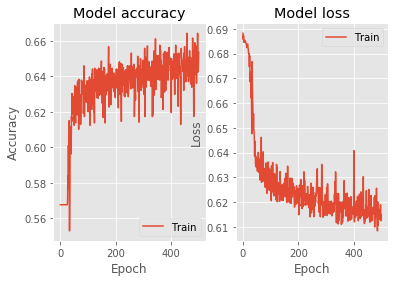

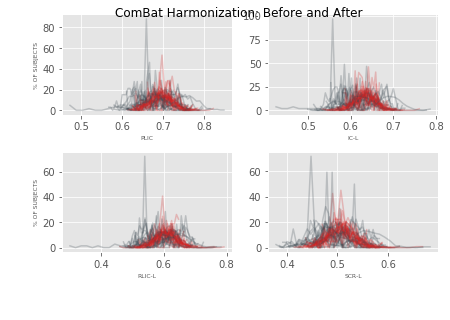

In [11]:
# Form Graph Path
pwd = os.getcwd()
savePathModel = os.path.join(pwd, 'model_fit.png')
savePathComBat = os.path.join(pwd, 'combat.png')

# Plot training & validation accuracy values
with plt.style.context('ggplot'):
    plt.subplot(121)
    plt.plot(history.history['acc'])
    # plt.plot(history.history['val_acc'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='lower right')

    # Plot training & validation loss values
    plt.subplot(122)
    plt.plot(history.history['loss'])
    # plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper right')
plt.savefig(savePathModel, dpi=600)

# Plot ComBat before & after
if harmonize:
    szSubPlot = 4                                                                   # Number of features to plot
    nBins = 20                                                                      # Number of bins

    uniqSites = dFrame.loc[:,'Site'].unique()
    with plt.style.context('ggplot'):                                               # Plotting style
        fig, axs = plt.subplots(np.sqrt(szSubPlot).astype(int), np.sqrt(szSubPlot).astype(int))
        for axsNum, axsIdx in enumerate(axs.reshape(-1)):                                              # Iterate over subplots
            plotIdx = random.randint(0,len(dFrame.loc[:,dBegin:dEnd].columns))      # Index random headers
            for s in uniqSites:
                siteIdx = dFrame.loc[:, 'Site'] == s
                nBefore, bBefore = np.histogram(data[siteIdx.values, plotIdx],      # Bin count before
                                               bins=nBins,
                                               density=True)
                nAfter, bAfter = np.histogram(cData[siteIdx.values, plotIdx],       # Bin count after
                                             bins=nBins,
                                             density=True)

                mBefore = np.zeros((nBins,))
                mAfter = np.zeros((nBins,))
                for i  in range(len(bBefore)-1):                                    # Get median of bin edges
                    mBefore[i] = np.median([bBefore[i], bBefore[i + 1]])            # Median of bin edges (before)
                    mAfter[i] = np.median([bAfter[i], bAfter[i + 1]])               # Median of bin edges (after)

                siteIdx = dFrame.loc[:,'Site'] == s                                 # Extract data for a site
                muBefore = np.mean(data[siteIdx.values, plotIdx])
                muAfter = np.mean(cData[siteIdx.values, plotIdx])
                stdBefore = np.std(data[siteIdx.values, plotIdx])
                stdAfter = np.std(cData[siteIdx.values, plotIdx])
                yBefore = scipy.stats.norm.pdf(mBefore, muBefore, stdBefore)
                yAfter = scipy.stats.norm.pdf(mAfter, muAfter, stdAfter)
                if plotType == 'Histogram':
                    yBefore = nBefore
                    yAfter = nAfter
                elif plotType == 'Normal':
                    yBefore = scipy.stats.norm.pdf(mBefore, muBefore, stdBefore)
                    yAfter = scipy.stats.norm.pdf(mAfter, muAfter, stdAfter)

                axsIdx.plot(mBefore, yBefore,                                       # Plot on subplot(axsIdx) before
                                  color='#3a4750',
                                  alpha=0.25)

                axsIdx.plot(mAfter, yAfter,                                         # Plot on subplot(axsIdx) after
                                  color='#d72323',
                                  alpha=0.25)

                if axsNum == 0 or axsNum == 2:
                    axsIdx.set_ylabel('% OF SUBJECTS',
                                      fontsize=6)

                axsIdx.set_xlabel(dFrame.loc[:, dBegin:dEnd].columns[plotIdx].upper(),
                                  fontsize=6)

        fig.legend(['Before ComBat', 'After ComBat'],                               # Legend
                   loc = 'lower right',
                   ncol=2,
                   fancybox=True,
                   bbox_to_anchor=(0.5,-0.1))
        plt.suptitle('ComBat Harmonization: Before and After')
        plt.subplots_adjust(wspace=0.2, hspace=0.5)

    plt.tight_layout()
    plt.savefig(savePathComBat, dpi=600)